<a href="https://colab.research.google.com/github/pfauda/python/blob/gh-pages/KillerStockPortfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Optimizador de portfolio de activos

In [2]:
# Instalación de librerias

In [20]:
!pip install yfinance

In [21]:
!pip install PyPortfolioOpt

In [22]:
!pip install pulp

In [6]:
# Importar las librerias de python
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt

In [7]:
# Cargar datos historicos
import yfinance as yf
import datetime as dt
#tickers = ['BABA', 'GOLD', 'BBD', 'VIST']
tickers = ['BABA', 'GOLD', 'BBD', 'VIST', 'CEPU.BA', 'TRAN.BA', 'CELU.BA', 'CECO2.BA', 'INVJ.BA']
df = pd.DataFrame()
for stock in tickers:
  data = yf.download(stock, start="2015-01-01", end=dt.date.today().strftime("%Y-%m-%d"))
  data.rename(columns={"Close": stock}, inplace=True)
  data.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)
  df = df.merge(data, right_index=True, left_index=True, how="outer")
df.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,BABA,GOLD,BBD,VIST,CEPU.BA,TRAN.BA,CELU.BA,CECO2.BA,INVJ.BA
Date,,,,,,,,,
2019-07-26,178.740005,17.059999,9.60,9.100,39.500000,45.849998,30.000000,10.50,9.100000
2019-07-29,177.020004,17.209999,9.54,10.000,40.099998,46.099998,30.500000,10.65,9.250000
2019-07-30,174.100006,17.010000,9.28,10.100,39.799999,46.450001,30.500000,10.75,10.000000
2019-07-31,173.110001,16.260000,9.04,10.020,40.450001,46.549999,29.799999,10.55,10.350000
2019-08-01,165.649994,16.950001,8.88,9.400,40.099998,45.650002,29.799999,10.80,10.150000
...,...,...,...,...,...,...,...,...,...
2020-12-22,255.830002,22.520000,5.23,2.710,36.200001,26.450001,21.150000,15.95,16.250000
2020-12-23,256.179993,22.830000,5.33,2.750,37.500000,26.650000,20.799999,15.80,16.650000
2020-12-28,222.360001,22.840000,5.31,2.590,36.200001,26.500000,21.000000,15.15,16.700001


In [8]:
# Importar las librerias de optimización de portfolio
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns 

In [9]:
# Calcular los retornos anualizados y la matriz de covarianza anualizada de los retornos diarios de los activos
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df, returns_data=False)

In [10]:
# Optimizar para el maximo ratio de retorno
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [11]:
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

OrderedDict([('BABA', 0.2284), ('GOLD', 0.13837), ('BBD', 0.0), ('VIST', 0.0), ('CEPU.BA', 0.02533), ('TRAN.BA', 0.24487), ('CELU.BA', 0.06231), ('CECO2.BA', 0.0871), ('INVJ.BA', 0.21363)])
Expected annual return: 26.8%
Annual volatility: 28.2%
Sharpe Ratio: 0.88


(0.2678405969845238, 0.28183681940157007, 0.8793762202921849)

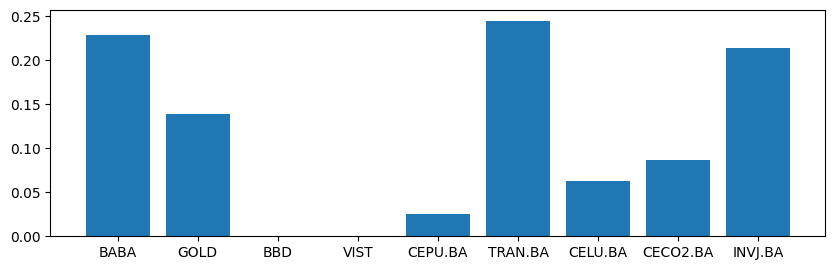

In [35]:
plt.bar(range(len(cleaned_weights)), list(cleaned_weights.values()), align='center')
plt.xticks(range(len(cleaned_weights)), list(cleaned_weights.keys()))
plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.show()

In [13]:
# Obtener las colocaciones discretas para cada acción de cada activo
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

portfolio_val = 5000
latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = portfolio_val)
allocation, leftover = da.lp_portfolio()
print("Papeles: ", allocation)
print("Fondos remanentes $:", leftover)

Papeles:  {'BABA': 5, 'GOLD': 30, 'BBD': 1, 'CEPU.BA': 3, 'TRAN.BA': 42, 'CELU.BA': 15, 'CECO2.BA': 28, 'INVJ.BA': 64}
Fondos remanentes $: 0.5899467468261719


In [14]:
# Crear una función para obtener los nombres de las companias
def get_company_name(symbol):
  url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query="+symbol+"&region=1&lang=es"
  result = requests.get(url).json()
  for r in result["ResultSet"]["Result"]:
    if r["symbol"] == symbol:
      return r["name"]

In [15]:
# Guardar el nombre de la compania en una lista
company_name = []
for symbol in allocation:
  company_name.append(get_company_name(symbol))

In [16]:
# Obtener los valores de las colocaciones
discrete_allocation_list = []
for symbol in allocation:
  discrete_allocation_list.append(allocation.get(symbol))

In [17]:
# Crear el dataframe para el portfolio
portfolio_df = pd.DataFrame(columns=["Nombre", "Ticker", "Acciones"+str(portfolio_val)])

In [18]:
portfolio_df["Nombre"] = company_name
portfolio_df["Ticker"] = allocation
portfolio_df["Acciones"+str(portfolio_val)] = discrete_allocation_list

In [19]:
portfolio_df

,Nombre,Ticker,Acciones5000
0,Alibaba Group Holding Limited,BABA,5
1,Barrick Gold Corporation,GOLD,30
2,Banco Bradesco S.A.,BBD,1
3,Central Puerto S.A.,CEPU.BA,3
4,Compañía de Transporte de Energía Eléctrica en...,TRAN.BA,42
5,Celulosa Argentina S.A.,CELU.BA,15
6,Enel Generación Costanera S.A.,CECO2.BA,28
7,Inversora Juramento S.A.,INVJ.BA,64
